In [14]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

import env

In [15]:
from typing import Tuple


def load_scenario_data(name: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    scenario_path = Path("../" / env.OUTPUT_DIR / name)
    # scenario_path = Path("../output-2024-06-03_22:30:31") / name

    trips_df: pd.DataFrame = None
    route_times = []
    elapsed_times = []
    for directory in scenario_path.iterdir():
        try:
            scenario_df = pd.read_csv(directory / "trips.csv", skipinitialspace=True)
            trips_df = pd.concat([trips_df, scenario_df], ignore_index=True)

            with open(directory / "results.txt", "r") as f:
                lines = f.readlines()
                route_times.append(float(lines[3].split()[2]))
                elapsed_times.append(float(lines[5].split()[2]))

        except Exception:
            pass

    routes_df = pd.DataFrame(
        {"ROUTE_TIMES": route_times, "ELAPSED_TIMES": elapsed_times}
    )

    return (trips_df, routes_df)

In [16]:
# scenarios_data = {
#     "ScenarioZero": load_scenario_data("ScenarioZero"),
#     "ScenarioOne": load_scenario_data("ScenarioOne"),
# }

from scenarios import ScenarioAllBelowCuttof, ScenarioZero


trips, route_results = load_scenario_data(ScenarioZero.__name__)
scenario_name = "Scenario 0"

In [17]:
from models import ReservationStatus


trips.loc[trips.RESERVATION_STATUS == str(ReservationStatus.REJECTED)]

,ID,DIRECTION,LOCATION_INDEX,RESERVED_AT,RESERVATION_STATUS
0,1,INBOUND,26,54,REJECTED
4,5,INBOUND,68,22,REJECTED
8,9,OUTBOUND,5,53,REJECTED
12,3,INBOUND,58,47,REJECTED
15,6,OUTBOUND,44,56,REJECTED
...,...,...,...,...,...
187,8,OUTBOUND,46,23,REJECTED
191,2,INBOUND,21,41,REJECTED
193,4,INBOUND,40,22,REJECTED
195,6,OUTBOUND,49,16,REJECTED


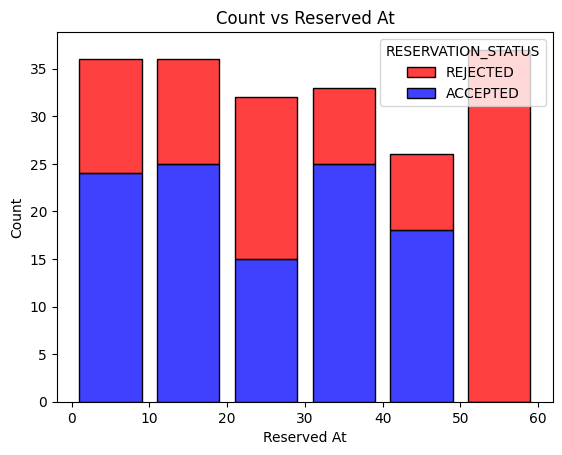

In [18]:
import seaborn as sns

colors = {"ACCEPTED": "blue", "REJECTED": "red"}

# Use seaborn to create the bar plot
trips_df = trips
sns.histplot(
    data=trips_df,
    x="RESERVED_AT",
    hue="RESERVATION_STATUS",
    multiple="stack",
    palette=colors,
    shrink=0.8,
    bins=range(0, 70, 10),
)
plt.xlabel("Reserved At")
plt.ylabel("Count")
plt.title("Count vs Reserved At")
plt.show()

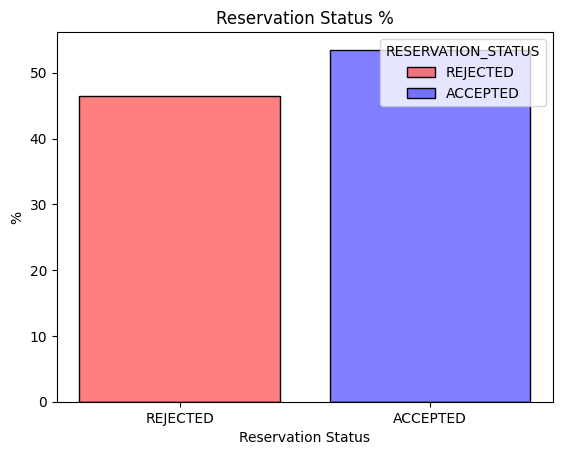

In [19]:
colors = {"ACCEPTED": "blue", "REJECTED": "red"}
sns.histplot(
    data=trips_df,
    x="RESERVATION_STATUS",
    stat="percent",
    hue="RESERVATION_STATUS",
    palette=colors,
    shrink=0.8,
    bins=range(0, 61, 5),
)

plt.xlabel("Reservation Status")
plt.ylabel("%")
plt.title("Reservation Status %")
plt.show()

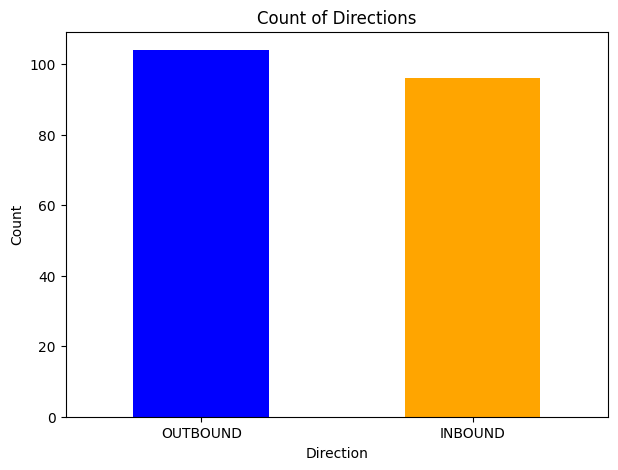

In [20]:
trips_df = trips
direction_counts = trips_df["DIRECTION"].value_counts()
plt.figure(figsize=(7, 5))
direction_counts.plot(kind="bar", color=["blue", "orange"])
plt.xlabel("Direction")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.title("Count of Directions")
plt.show()

In [21]:
def plot_kde_for(df, x: str, hue: str = None, pallete: list = None):
    sns.kdeplot(
        data=df,
        x=x,
        hue=hue,
        fill=True,
        common_norm=False,
        palette=pallete,
        alpha=0.5,
        linewidth=0,
    )


routes_df = None
scenario_routes_df = route_results
scenario_routes_df["NAME"] = scenario_name
routes_df = pd.concat([routes_df, scenario_routes_df], ignore_index=True)

# plot_kde_for(routes_df, "ROUTE_TIMES", "NAME", ["red", "blue"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Route times (Minutes)')

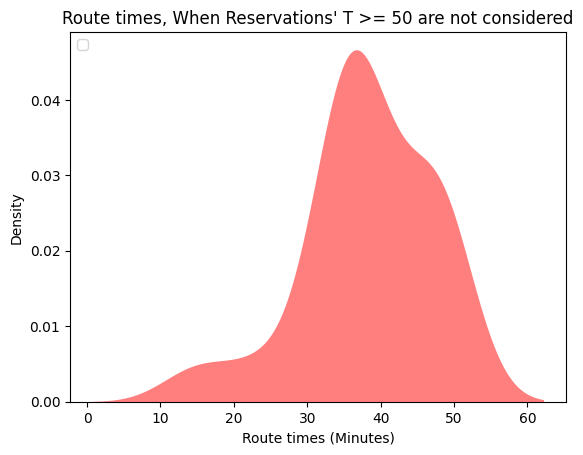

In [22]:
scenario_zero_routes_df = routes_df[routes_df["NAME"] == scenario_name]

plot_kde_for(scenario_zero_routes_df, "ROUTE_TIMES", "NAME", ["red"])
plt.title(
    f"Route times, When Reservations' T >= {env.RESERVATION_CUTOFF} are not considered"
)
plt.legend(loc="upper left")
plt.xlabel("Route times (Minutes)")

Text(0.5, 0, 'Elapsed time (Seconds)')

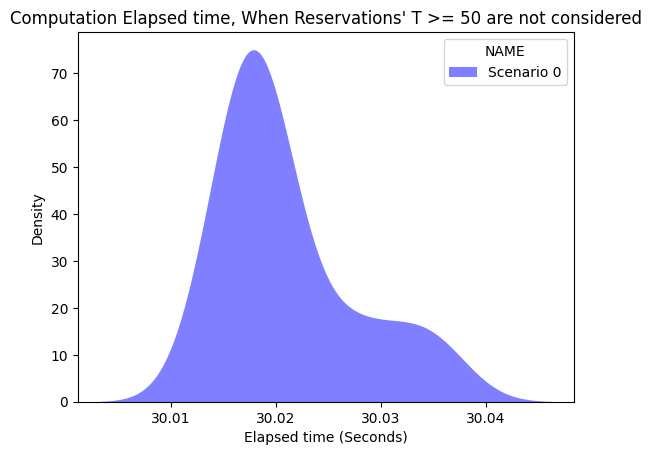

In [23]:
plot_kde_for(scenario_zero_routes_df, "ELAPSED_TIMES", "NAME", ["blue"])
plt.title(
    f"Computation Elapsed time, When Reservations' T >= {env.RESERVATION_CUTOFF} are not considered"
)
plt.xlabel("Elapsed time (Seconds)")

/tmp/ipykernel_7701/3955671622.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


<Axes: xlabel='ROUTE_TIMES', ylabel='Count'>

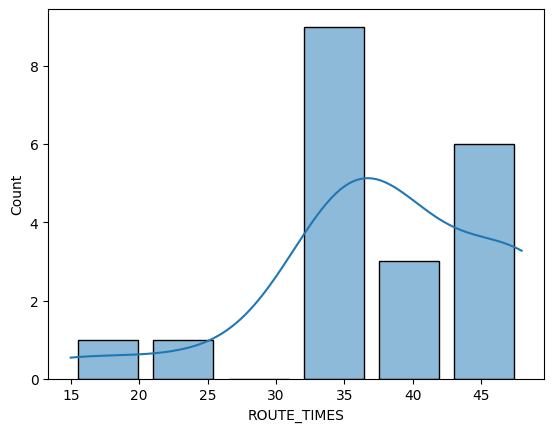

In [24]:
sns.histplot(
    data=scenario_zero_routes_df,
    x="ROUTE_TIMES",
    palette=colors,
    stat="count",
    shrink=0.8,
    # bins=range(0, 70, 10),
    common_norm=False,
    kde=True,
)

In [25]:
# scenario_one_routes_df = routes_df[routes_df["NAME"] == "ScenarioOne"]

# plot_kde_for(scenario_one_routes_df, "ROUTE_TIMES", "NAME", ["blue"])
# plt.title("When Reservations' T >= 50 are considered")
# plt.legend(loc="upper left")

In [26]:
import numpy as np

# Calculate the mean and variance for each column
mean = np.mean(route_results["ROUTE_TIMES"], axis=0)
variance = np.var(route_results["ROUTE_TIMES"], axis=0)

print("Mean Route time: ", mean, " minutes")
print("Route time Variance: ", variance, " minutes")

Mean Route time:  38.218500000000006  minutes
Route time Variance:  70.86830275  minutes
